# Predictive Lead Conversion Using Metadata

This notebook uses your cleaned dataset to build a predictive model for lead conversion. Follow the steps below for data analysis, model building, and evaluation.

**Workflow:**
1. Load the cleaned data
2. Exploratory Data Analysis (EDA)
3. Feature preparation
4. Train/test split and scaling
5. Model training and evaluation
6. Save the trained model


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc
import joblib

In [16]:
df = pd.read_csv("Leads.csv")
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Tags,Lead Profile,City,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0,0,0.0,Page Visited on Website,India,Select,Select,Unemployed,Better Career Prospects,No,Interested in other courses,Select,Select,No,Modified
1,API,Organic Search,No,No,0,5,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,Ringing,Select,Select,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,Will revert after reading the email,Potential Lead,Mumbai,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,Ringing,Select,Mumbai,No,Modified
4,Landing Page Submission,Google,No,No,1,2,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,Will revert after reading the email,Select,Mumbai,No,Modified


In [17]:
print('Shape:', df.shape)
df.info()
print(df.describe())

Shape: (9240, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 20 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9240 non-null   int64  
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9240 non-null   object 
 9   Country                           

In [18]:
print('Missing values per column:')
print(df.isnull().sum())

Missing values per column:
Lead Origin                                      0
Lead Source                                      0
Do Not Email                                     0
Do Not Call                                      0
Converted                                        0
TotalVisits                                      0
Total Time Spent on Website                      0
Page Views Per Visit                             0
Last Activity                                    0
Country                                          0
Specialization                                   0
How did you hear about X Education               0
What is your current occupation                  0
What matters most to you in choosing a course    0
Search                                           0
Tags                                             0
Lead Profile                                     0
City                                             0
A free copy of Mastering The Interview           0
Last

In [19]:
# Fill numeric columns with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())
# Fill categorical columns with 'Unknown'
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')

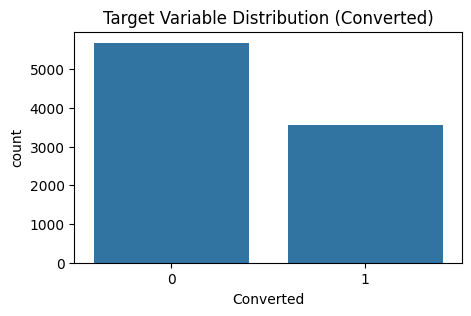

In [20]:
plt.figure(figsize=(5,3))
sns.countplot(x='Converted', data=df)
plt.title('Target Variable Distribution (Converted)')
plt.show()

In [21]:
if 'TotalVisits' in df.columns and 'Page Views Per Visit' in df.columns:
    df['Total_Interactions'] = df['TotalVisits'] + df['Page Views Per Visit']
if 'Tags' in df.columns:
    df['Num_Tags'] = df['Tags'].apply(lambda x: len(str(x).split(',')) if x != 'Not Provided' else 0)

In [22]:
y = df['Converted']
X = df.drop('Converted', axis=1)
X_encoded = pd.get_dummies(X, drop_first=True)
print('Encoded feature shape:', X_encoded.shape)

Encoded feature shape: (9240, 178)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Train shape:', X_train_scaled.shape)
print('Test shape:', X_test_scaled.shape)

Train shape: (7392, 178)
Test shape: (1848, 178)


In [24]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid.fit(X_train_scaled, y_train)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}


In [25]:
best_rf = RandomForestClassifier(**grid.best_params_, random_state=42)
best_rf.fit(X_train_scaled, y_train)
y_pred = best_rf.predict(X_test_scaled)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("✅ Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.939935064935065
✅ Confusion Matrix:
 [[1067   40]
 [  71  670]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1107
           1       0.94      0.90      0.92       741

    accuracy                           0.94      1848
   macro avg       0.94      0.93      0.94      1848
weighted avg       0.94      0.94      0.94      1848



In [26]:
y_pred = best_rf.predict(X_test_scaled)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("✅ Classification Report:\n", classification_report(y_test, y_pred))

✅ Accuracy: 0.939935064935065
✅ Confusion Matrix:
 [[1067   40]
 [  71  670]]
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1107
           1       0.94      0.90      0.92       741

    accuracy                           0.94      1848
   macro avg       0.94      0.93      0.94      1848
weighted avg       0.94      0.94      0.94      1848



C:\Users\uttam\AppData\Local\Temp\ipykernel_19636\1503108361.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


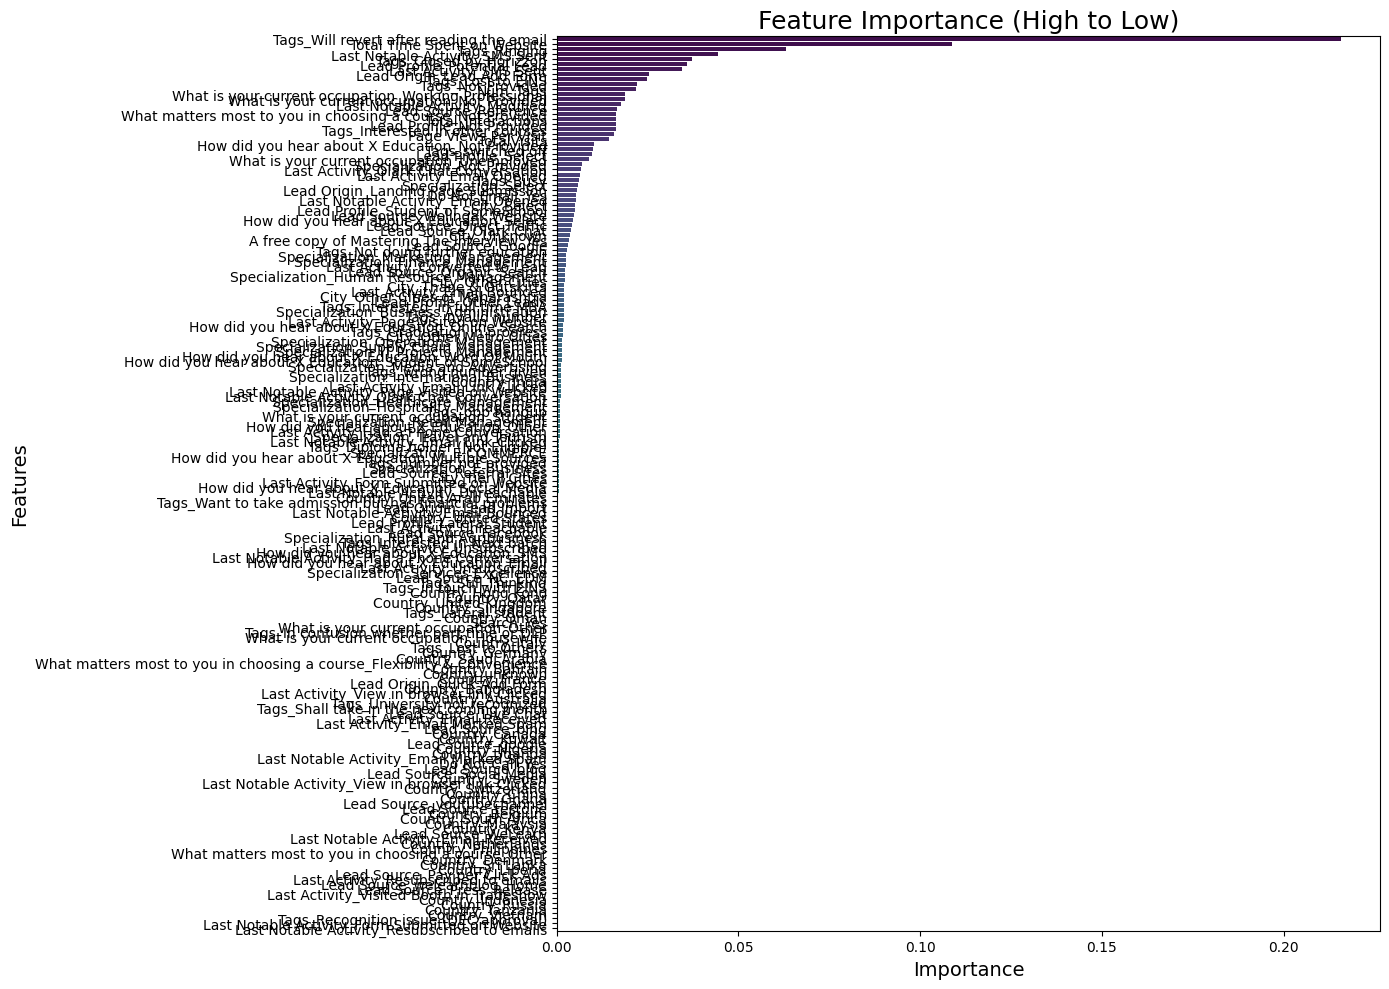

In [27]:
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df.to_csv("Feature_Importance_Prioritized.csv", index=False)

plt.figure(figsize=(14, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title("Feature Importance (High to Low)", fontsize=18)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)
plt.tight_layout()
plt.show()

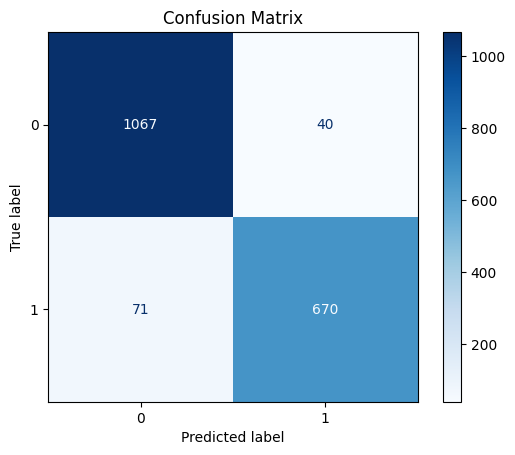

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

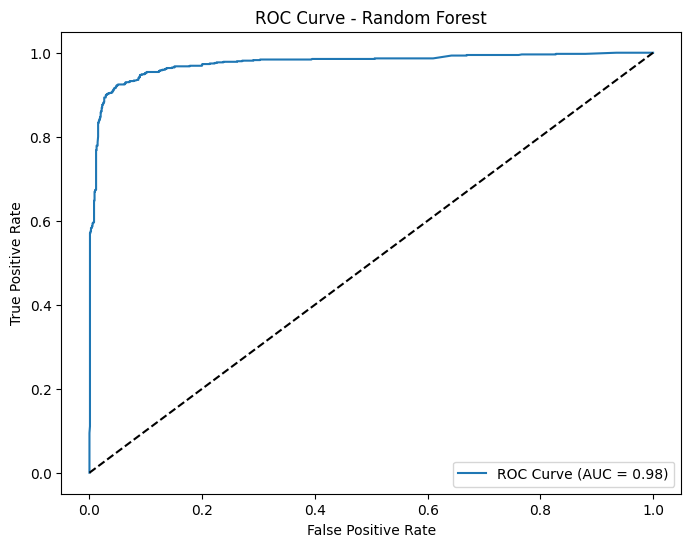

In [29]:
y_pred_prob = best_rf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

In [30]:
joblib.dump(best_rf, "best_random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(X_encoded.columns, "model_columns.pkl")

['model_columns.pkl']

In [31]:
def predict_new_lead(data_dict):
    import pandas as pd
    import joblib

    model = joblib.load("best_random_forest_model.pkl")
    scaler = joblib.load("scaler.pkl")
    columns = joblib.load("model_columns.pkl")

    df_new = pd.DataFrame([data_dict])
    df_new_encoded = pd.get_dummies(df_new)
    df_new_encoded = df_new_encoded.reindex(columns=columns, fill_value=0)
    df_new_scaled = scaler.transform(df_new_encoded)
    prediction = model.predict(df_new_scaled)
    return prediction[0]